# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.types import StringType, DoubleType, IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, StringIndexer, PCA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
# create a Spark session
spark_session = SparkSession.builder.appName('Sparkify').getOrCreate()

In [4]:
#Let's check if the change went through
spark_session.sparkContext.getConf().getAll()

[('spark.app.id', 'local-1574543959753'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.host', '86f3679f683e'),
 ('spark.app.name', 'Sparkify'),
 ('spark.driver.port', '43073'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [5]:
spark_session

# Load and Clean Dataset
We begin with provided mini-dataset file called `mini_sparkify_event_data.json`. We load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [7]:
# read file
path = "mini_sparkify_event_data.json"
user_log = spark_session.read.json(path)

In [8]:
user_log.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [9]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [11]:
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [12]:
user_log.count()

286500

In [13]:
# Drop Rows with Missing Values
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
user_log_valid.count()

286500

As we can see all the log lines have userId and sessionId.

# 2. Exploratory Data Analysis
When working with the full dataset, it is interesting to perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, we are provided with a small subset of data  to explore.

### Define Churn

Once we've done some preliminary analysis, we will create a column `Churn` to use as the label for our model. The values `Cancellation Confirmation`events are to define the churn, which happen for both paid and free users. We will  also look into the `Downgrade` events.

### Explore Data
Once we've defined churn, we perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. We start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In order to be able to create the Churn and Downgrade columns we need to check the existing page column's values

In [14]:
# Lets check all the pages visited by the users
pages_df = user_log.select("page").dropDuplicates().sort("page")
pages_df.show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [15]:
def flag_row(df, column_name, column_value, new_column_name):
    '''
    Creates a new flag column called new_column_name, based on the value passed with the column_value. 
    If the value of the column column_name equals to column_value the corresponding value of new_column_name wille be 1.
    othervise 0.
    
    :param: df : dataframe 
    :param: column_name : The name of the column to explore.
    :param: column_value : The searched value
    :param: new_column_name : The name of the new flag column
    :type column_name: The name of the column to explore
    :type column_value: The type defined for the column column_name
    :type new_column_name: String, the name of the new flag column
    :return:  the modified dataframe
    :rtype: dataframe
    '''
    
    flag_downgrade_event = udf(lambda x: 1 if x == column_value else 0, IntegerType())
    df = df.withColumn(new_column_name, flag_downgrade_event(column_name))
    return df

### 2.1. Users perform Churn 

In [16]:
user_log.filter("page = 'Cancellation Confirmation'").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [17]:
user_log = flag_row(user_log, "page", 'Cancellation Confirmation', "Churn")

In [18]:
user_log.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|Churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|153

### 2.2 Users Downgrade Their Accounts

Let's find the users who downgraded their accounts and  flag those log entries. A window function and cumulative sum is used to distinguish each user's data as either pre or post downgrade events.

In [19]:
user_log.filter("page = 'Submit Downgrade'").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+
|  null|Logged In|     Kael|     M|           47|   Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|    0|
|  null|Logged In|   Calvin|     M|           17|Marshall|  null| paid|      Pittsburgh, PA|   PUT|Submit Downgrade|1537120757000|      313|null|   307|1538516445000|"Mozilla/5.0 (Mac...|    38|  

In [20]:
user_log = flag_row(user_log, "page", 'Submit Downgrade', "Downgraded")

In [21]:
user_log.show(3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|Churn|Downgraded|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-----+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|    0|         0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| f

As we added new columns, we can go on with our analysis. Let's begin with userId.

In [22]:
# Lets check all the user ids in our dataset
user_ids_df = user_log.select("userId").dropDuplicates().sort("userId")
user_ids_df.show()
user_ids_df.count()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



226

In [23]:
user_log.select(["userId", "sessionId", "page", "song"]).where(user_log.userId == "10").collect()

[Row(userId='10', sessionId=9, page='NextSong', song='Ses Monuments'),
 Row(userId='10', sessionId=9, page='NextSong', song='Morning Sky'),
 Row(userId='10', sessionId=9, page='NextSong', song="Du Hast'n Freund In Mir (You've Got A Friend In Me)"),
 Row(userId='10', sessionId=9, page='NextSong', song='Playera'),
 Row(userId='10', sessionId=9, page='NextSong', song="Burnin' For You"),
 Row(userId='10', sessionId=9, page='NextSong', song='Sky Is Falling'),
 Row(userId='10', sessionId=9, page='NextSong', song='Skinhead Stomp'),
 Row(userId='10', sessionId=9, page='Thumbs Up', song=None),
 Row(userId='10', sessionId=9, page='NextSong', song="You're The One"),
 Row(userId='10', sessionId=9, page='NextSong', song='Strange Days'),
 Row(userId='10', sessionId=9, page='NextSong', song='Addicted To Love'),
 Row(userId='10', sessionId=9, page='Add Friend', song=None),
 Row(userId='10', sessionId=9, page='Add Friend', song=None),
 Row(userId='10', sessionId=9, page='NextSong', song='Desert Sand'),

In [26]:
# For the rest of project we will work with not empty userIds users' logs.
user_log = user_log.filter(user_log["userId"] != "")
user_log.count()

278154

In [27]:
#Check the result
df = user_log.select("userId").groupby("userId").count().orderBy(desc("count"))
df.show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
|    74| 2887|
+------+-----+
only showing top 20 rows



Once filtered all the unregistrated users' logs we can go on our analysis.

In [28]:
#Column analyse: artist
df = user_log.select("artist").groupby("artist").count().orderBy(desc("count"))
df.show()
df.count()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



17656

In [29]:
# Get missing value rate for artist column
50046/278154

0.17992191376000344

In [30]:
#Let's replace null with values 'unknown_artist'
user_log = user_log.na.fill('unknown_artist', "artist")

In [31]:
# How many songs were played from the most played artist?
most_played_artist_count = user_log.select("artist").groupby("artist").count().orderBy(desc("count"))
most_played_artist_count.show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      unknown_artist|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



In [32]:
#Column analyse : auth
df = user_log.select("auth").groupby("auth").count().orderBy(desc("count"))
df.show()
df.count()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



2

In [33]:
#Column analyse : firstName
df = user_log.select("firstName").groupby("firstName").count().orderBy(desc("count"))
df.show()
df.count()

+---------+-----+
|firstName|count|
+---------+-----+
|   Payton| 9632|
|    Riley| 7970|
|   Lucero| 6880|
|   Emilia| 5732|
|     Emma| 5478|
|   Joseph| 5209|
|    Colin| 4989|
|   Nicole| 4825|
|   Joshua| 4654|
|  Brayden| 4621|
|  Alyssia| 4428|
|   Jayden| 4268|
|   Dillyn| 4257|
|   Sophia| 4246|
|   Bryson| 4172|
|  Katiana| 3769|
|   Oliver| 3657|
|    Kaleb| 3603|
|   Samuel| 3486|
|    Alexi| 3437|
+---------+-----+
only showing top 20 rows



189

In [34]:
#Column analyse :lastName
df = user_log.select("lastName").groupby("lastName").count().orderBy(desc("count"))
df.show()
df.count()

+----------+-----+
|  lastName|count|
+----------+-----+
|  Campbell|14060|
|      Reed| 9284|
|  Williams| 8410|
|    Taylor| 7230|
|   Johnson| 6106|
|    Larson| 6105|
|     House| 5732|
|  Thompson| 5217|
|     Jones| 4831|
|      Beck| 4825|
|     Allen| 4659|
|   Stewart| 4461|
|    Miller| 4428|
|    Thomas| 4370|
|Richardson| 4257|
|  Phillips| 4002|
|  Robinson| 3890|
|   Daniels| 3769|
|  Roberson| 3761|
|      Long| 3483|
+----------+-----+
only showing top 20 rows



173

As we have unique user identifier userId we can skip the use of the columns firstName and lastName.

In [35]:
#Column analyse : gender
df = user_log.select("gender").groupby("gender").count().orderBy(desc("count"))
df.show()
df.count()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



2

In [36]:
user_log = user_log.withColumn("gender", \
              when(user_log["gender"] == 'F', 'Female').otherwise(user_log["gender"]))

In [37]:
user_log = user_log.withColumn("gender", \
              when(user_log["gender"] == 'M', 'Male').otherwise(user_log["gender"]))

In [38]:
user_log.select("gender").groupby("gender").count().orderBy(desc("count")).show()

+------+------+
|gender| count|
+------+------+
|Female|154578|
|  Male|123576|
+------+------+



In [39]:
# Column analyse : itemInSession
df = user_log.select("itemInSession").groupby("itemInSession").count().orderBy(desc("count"))
df.show()
df.count()

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            2| 2941|
|            3| 2917|
|            4| 2887|
|            5| 2836|
|            1| 2818|
|            6| 2803|
|            7| 2776|
|            8| 2735|
|            9| 2693|
|            0| 2689|
|           10| 2633|
|           11| 2596|
|           12| 2556|
|           13| 2513|
|           14| 2485|
|           15| 2456|
|           16| 2428|
|           17| 2385|
|           18| 2345|
|           19| 2322|
+-------------+-----+
only showing top 20 rows



1311

In [42]:
# Column analyse : length
user_log.select("length").groupby("length").count().orderBy(desc("count")).show()

+---------+-----+
|   length|count|
+---------+-----+
|     null|50046|
| 239.3073| 1205|
|348.57751| 1037|
|201.79546|  908|
|655.77751|  730|
|277.15873|  645|
|219.66322|  585|
|224.67873|  522|
|220.89098|  511|
|236.09424|  450|
|252.21179|  438|
|233.69098|  436|
|122.04363|  412|
|195.94404|  408|
|181.21098|  384|
|225.17506|  379|
|231.81016|  378|
|216.76363|  362|
|302.05342|  345|
|233.89995|  314|
+---------+-----+
only showing top 20 rows



In [40]:
# It seems to be the length of listedned part of the song so it will be interesting to keep this information. 
# Lets replace null values by value 0.
user_log = user_log.na.fill(0.0, "length")
user_log.select("length").groupby("length").count().orderBy(desc("count")).show()

+---------+-----+
|   length|count|
+---------+-----+
|      0.0|50046|
| 239.3073| 1205|
|348.57751| 1037|
|201.79546|  908|
|655.77751|  730|
|277.15873|  645|
|219.66322|  585|
|224.67873|  522|
|220.89098|  511|
|236.09424|  450|
|252.21179|  438|
|233.69098|  436|
|122.04363|  412|
|195.94404|  408|
|181.21098|  384|
|225.17506|  379|
|231.81016|  378|
|216.76363|  362|
|302.05342|  345|
|233.89995|  314|
+---------+-----+
only showing top 20 rows



In [41]:
# Column analyse : level
user_log.select("level").groupby("level").count().orderBy(desc("count")).show()

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+



In [42]:
#Column analyze : location
df = user_log.select("location").groupby("location").count().orderBy(desc("count"))
df.show()
df.count()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Los Angeles-Long ...|30131|
|New York-Newark-J...|23684|
|Boston-Cambridge-...|13873|
|Houston-The Woodl...| 9499|
|Charlotte-Concord...| 7780|
|Dallas-Fort Worth...| 7605|
|Louisville/Jeffer...| 6880|
|Philadelphia-Camd...| 5890|
|Chicago-Napervill...| 5114|
|    St. Louis, MO-IL| 4858|
|Phoenix-Mesa-Scot...| 4846|
|Vineland-Bridgeto...| 4825|
|          Wilson, NC| 4659|
|Denver-Aurora-Lak...| 4453|
|           Ionia, MI| 4428|
|San Antonio-New B...| 4373|
|        Danville, VA| 4257|
|Atlanta-Sandy Spr...| 4236|
|New Haven-Milford...| 4007|
|         Jackson, MS| 3839|
+--------------------+-----+
only showing top 20 rows



114

In [43]:
#Column analyze : method
df = user_log.select("method").groupby("method").count().orderBy(desc("count"))
df.show()
df.count()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



2

It seems to be technical column so it may give us some insights about user's interaction with the platform. Let's keep this column for further analysis.

In [44]:
#Column analyse : sessionId
user_log.describe("sessionId").show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            278154|
|   mean|1042.5616241362698|
| stddev| 726.5010362219813|
|    min|                 1|
|    max|              2474|
+-------+------------------+



In [45]:
df = user_log.select("sessionId").dropDuplicates().sort("sessionId")
df.show()
df.count()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



2312

In [46]:
# Column analyse : page
df = user_log.select("page").dropDuplicates().sort("page")
df.show()
df.count()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



19

In [47]:
#Column analyze : registration
df = user_log.select("registration").groupby("registration").count().orderBy(desc("count"))
df.show()
df.count()


+-------------+-----+
| registration|count|
+-------------+-----+
|1529027541000| 9632|
|1536403972000| 7230|
|1536642109000| 6880|
|1538336771000| 5732|
|1532224335000| 4825|
|1537611935000| 4659|
|1537082511000| 4428|
|1534133898000| 4370|
|1537811988000| 4257|
|1537812949000| 3769|
|1521380675000| 3761|
|1536988041000| 3603|
|1532482662000| 3437|
|1537982255000| 3214|
|1538331630000| 3191|
|1538227408000| 3102|
|1528780738000| 3051|
|1533398428000| 3014|
|1538069638000| 2891|
|1537365219000| 2887|
+-------------+-----+
only showing top 20 rows



225

In [48]:
#Check the year of registration
get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year)
df = user_log.withColumn("registration_year", get_year(user_log.registration))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='Male', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, Downgraded=0, registration_year='2018')

In [49]:
df = df.select("registration_year").groupby("registration_year").count().orderBy(desc("count"))

In [50]:
df.show()

+-----------------+------+
|registration_year| count|
+-----------------+------+
|             2018|278154|
+-----------------+------+



As there is only one year let's check month. But with a bigger dataset we may have several valuesfor year, so let's keep it.

In [51]:
user_log = user_log.withColumn("registration_year", get_year(user_log.registration))

In [52]:
#Check the month of registration
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
df = user_log.withColumn("registration_month", get_month(user_log.registration))
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='Male', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, Downgraded=0, registration_year='2018', registration_month='9')

In [53]:
df = df.select("registration_month").groupby("registration_month").count().orderBy(desc("count"))
df.show()
df.count()

+------------------+------+
|registration_month| count|
+------------------+------+
|                 9|165635|
|                 8| 48386|
|                 7| 33519|
|                 6| 20523|
|                 3|  3761|
|                 5|  2391|
|                11|  2257|
|                10|  1682|
+------------------+------+



8

Lets add this column to our dataset.

In [54]:
user_log = user_log.withColumn("registration_month", get_month(user_log.registration))

In [55]:
#Column analyze : song
df = user_log.select("song").groupby("song").count().orderBy(desc("count"))
df.show()
df.count()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|50046|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



58481

In the column song, the are too many missing values as well as to many different values. So for the moment we wont use this column.

In [56]:
#Column analyze : status
df = user_log.select("status").groupby("status").count().orderBy(desc("count"))
df.show()
#df.count()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



The column status seems to be a technical column. If we check the list of HTTP status codes, we see that :
* 2xx Success, 200 OK 
* 3xx Redirection,  307 Temporary Redirect (since HTTP/1.1)
* 4xx Client errors, 404 Not Found

The users experiencing technical errors are more susceptive not to be happy with the platform and to churn. So let's keep this column as categorical column.

In [57]:
#Column analyze : userAgent
df = user_log.select("userAgent").groupby("userAgent").count().orderBy(desc("count"))

In [58]:
#Column analyze : userAgent
df.show()
df.count()

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Win...|22751|
|"Mozilla/5.0 (Mac...|19611|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...|17348|
|Mozilla/5.0 (Wind...|16700|
|"Mozilla/5.0 (Win...|15395|
|"Mozilla/5.0 (Win...|14598|
|Mozilla/5.0 (Maci...|10300|
|"Mozilla/5.0 (iPa...| 8912|
|Mozilla/5.0 (comp...| 8624|
|"Mozilla/5.0 (Mac...| 8094|
|"Mozilla/5.0 (Win...| 7923|
|"Mozilla/5.0 (Mac...| 7906|
|"Mozilla/5.0 (Win...| 7624|
|"Mozilla/5.0 (iPh...| 6417|
|Mozilla/5.0 (Wind...| 5989|
|"Mozilla/5.0 (Mac...| 5716|
|"Mozilla/5.0 (Win...| 5238|
|"Mozilla/5.0 (Win...| 4917|
|Mozilla/5.0 (Wind...| 4663|
+--------------------+-----+
only showing top 20 rows



56

Let's do some more analysis to understand better our data set.

In [60]:
# Distribution of genders in the data set..
nb_female = user_log.select(["userId"]).where("gender = 'Female'").dropDuplicates().count()
nb_male = user_log.select(["userId"]).where("gender = 'Male'").dropDuplicates().count()
nb_unkown_gender = user_log.select(["userId"]).where("gender = 'unknown_gender'").dropDuplicates().count()
print('There are {} female, {} male and {} unknow_gender users  and in our dataset.'.format(nb_female, nb_male, nb_unkown_gender))

There are 104 female, 121 male and 0 unknow_gender users  and in our dataset.


In [61]:
# How many songs were played from the most played artist?
most_played_artist_count = user_log.select("artist").groupby("artist").count().orderBy(desc("count")).show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      unknown_artist|50046|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
|              Eminem|  953|
|           Radiohead|  884|
|     Alliance Ethnik|  876|
|               Train|  854|
|        Taylor Swift|  840|
|         OneRepublic|  828|
|         The Killers|  822|
|         Linkin Park|  787|
|         Evanescence|  781|
|            Harmonia|  729|
+--------------------+-----+
only showing top 20 rows



### Calculating Statistics by Hour

In [62]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log = user_log.withColumn("hour", get_hour(user_log.ts))
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='Male', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, Downgraded=0, registration_year='2018', registration_month='9', hour='0')

In [63]:
songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

In [64]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [65]:
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

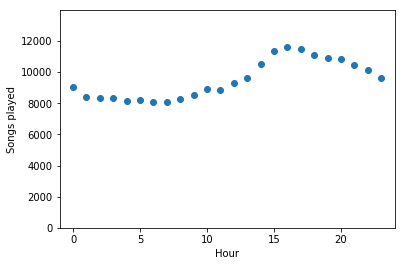

In [66]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [67]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
user_log = user_log.withColumn("phase", Fsum("downgraded").over(windowval))
#user_log.select(["userId", "firstname", "page", "level", "song", "phase"]).where(user_log.userId == "141").collect()

In [68]:
def save_as_csv(data, path):
    data.write.save(path, format="csv", header=True)
    
def load_from_csv(spark, path):
    data = spark.read.csv(path, header=True)
    return data


In [69]:
path = "data/sparkify_log_small_6.csv"
save_as_csv(user_log, path)

In [70]:
path = "data/sparkify_log_small_6.csv"
user_log = load_from_csv(spark_session, path)

In [71]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: string (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: string (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- song: string (nullable = true)
 |-- status: string (nullable = true)
 |-- ts: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- Downgraded: string (nullable = true)
 |-- registration_year: string (nullable = true)
 |-- registration_month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- phase: string (nullable = true)



# 3. Feature Engineering
Once we have familiarized ourself with the data, we build out the features to train your model on. To work with the full dataset, we can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that our script is scalable, using the best practices discussed in Lesson 3
- Try our script on the full data set, debugging your script if necessary

Let's begin by defining numerical and categorical columns.

In [72]:
numerical_columns = [
        'itemInSession',
        'length']

In [76]:
categorical_columns =[
    "auth",
    "artist",
    "gender",
    "level",
    "page",
    "status",
    "userId",
    "method",
    "Churn",
    "Downgraded",
    "phase",
    "registration_year",
    "registration_month",
    "hour",
]

In [77]:
all_columns = categorical_columns.copy()
for col in numerical_columns:
    all_columns.append(col)
all_columns

['auth',
 'artist',
 'gender',
 'level',
 'page',
 'status',
 'userId',
 'method',
 'Churn',
 'Downgraded',
 'phase',
 'registration_year',
 'registration_month',
 'hour',
 'itemInSession',
 'length']

In [78]:
registreted_user_log = user_log.select(all_columns)

In [79]:
# Change the type of numerical features tu integer
for col in numerical_columns:
    registreted_user_log = registreted_user_log.withColumn(col,registreted_user_log[col].cast(IntegerType()))

In [80]:
assembler = VectorAssembler(inputCols=numerical_columns, outputCol="num_features")
registreted_user_log = assembler.transform(registreted_user_log)
standard_scaler = StandardScaler(inputCol="num_features", outputCol="SScaler_num_features", withMean=True, withStd=True)
standard_scaler_model = standard_scaler.fit(registreted_user_log)
registreted_user_log = standard_scaler_model.transform(registreted_user_log)

In [81]:
for col in categorical_columns:
    indexer = StringIndexer(inputCol=col, outputCol="Idx_"+col)
    registreted_user_log = indexer.fit(registreted_user_log).transform(registreted_user_log)


In [82]:
registreted_user_log.printSchema()

root
 |-- auth: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- level: string (nullable = true)
 |-- page: string (nullable = true)
 |-- status: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- method: string (nullable = true)
 |-- Churn: string (nullable = true)
 |-- Downgraded: string (nullable = true)
 |-- phase: string (nullable = true)
 |-- registration_year: string (nullable = true)
 |-- registration_month: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- itemInSession: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- num_features: vector (nullable = true)
 |-- SScaler_num_features: vector (nullable = true)
 |-- Idx_auth: double (nullable = false)
 |-- Idx_artist: double (nullable = false)
 |-- Idx_gender: double (nullable = false)
 |-- Idx_level: double (nullable = false)
 |-- Idx_page: double (nullable = false)
 |-- Idx_status: double (nullable = false)
 |-- Idx_us

In [83]:
new_categorical_columns = []
for col in categorical_columns:
    new_categorical_columns.append("Idx_" + col)

In [84]:
new_categorical_columns

['Idx_auth',
 'Idx_artist',
 'Idx_gender',
 'Idx_level',
 'Idx_page',
 'Idx_status',
 'Idx_userId',
 'Idx_method',
 'Idx_Churn',
 'Idx_Downgraded',
 'Idx_phase',
 'Idx_registration_year',
 'Idx_registration_month',
 'Idx_hour']

In [85]:
new_numerical_columns = "SScaler_num_features"

In [86]:
new_all_columns = new_categorical_columns.copy()
new_all_columns.append(new_numerical_columns)
new_all_columns

['Idx_auth',
 'Idx_artist',
 'Idx_gender',
 'Idx_level',
 'Idx_page',
 'Idx_status',
 'Idx_userId',
 'Idx_method',
 'Idx_Churn',
 'Idx_Downgraded',
 'Idx_phase',
 'Idx_registration_year',
 'Idx_registration_month',
 'Idx_hour',
 'SScaler_num_features']

In [87]:
#The list of column to keep
processed_user_log = registreted_user_log.select(new_all_columns)

In [88]:
processed_user_log.columns

['Idx_auth',
 'Idx_artist',
 'Idx_gender',
 'Idx_level',
 'Idx_page',
 'Idx_status',
 'Idx_userId',
 'Idx_method',
 'Idx_Churn',
 'Idx_Downgraded',
 'Idx_phase',
 'Idx_registration_year',
 'Idx_registration_month',
 'Idx_hour',
 'SScaler_num_features']

# 4. Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### 4.1. Train Test Split

In [90]:
rest, validation = processed_user_log.randomSplit([0.7, 0.3], seed = 42)
print("Training Dataset Count: " + str(rest.count()))
print("Test Dataset Count: " + str(validation.count()))

Training Dataset Count: 194863
Test Dataset Count: 83291


### 4.2. Build Pipeline

In [91]:
features = []
for col in processed_user_log.columns:
    if col not in ["Idx_Churn", 'Idx_Downgraded'] :
        features.append(col)

In [92]:
features

['Idx_auth',
 'Idx_artist',
 'Idx_gender',
 'Idx_level',
 'Idx_page',
 'Idx_status',
 'Idx_userId',
 'Idx_method',
 'Idx_phase',
 'Idx_registration_year',
 'Idx_registration_month',
 'Idx_hour',
 'SScaler_num_features']

In [93]:
assembler = VectorAssembler(inputCols = features, outputCol='features')
pca = PCA(k=10, inputCol='features', outputCol='pcaFeature')
churn_indexer = StringIndexer(inputCol="Idx_Churn", outputCol="label")
lr = LogisticRegression(maxIter=10, regParam=0.3)
churn_pipeline = Pipeline (stages=[assembler, pca, churn_indexer, lr])

In [94]:
assembler = VectorAssembler(inputCols = features, outputCol='features')
pca = PCA(k=10, inputCol='features', outputCol='pcaFeature')
indexer = StringIndexer(inputCol="Idx_Downgraded", outputCol="label")
lr = LogisticRegression(maxIter=10, regParam=0.3)
downgraded_pipeline = Pipeline (stages=[assembler, pca, indexer, lr])

### 4.3. Tune Model


In [95]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter,[100, 50]) \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()


churn_crossval = CrossValidator(estimator=churn_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

downgraded_crossval = CrossValidator(estimator=downgraded_pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

After training the model when we check the average cross-validation metrics by avgMetrics.

In [96]:
churn_model = churn_crossval.fit(rest)
print(churn_model.avgMetrics)
churn_results = churn_model.transform(validation)

[0.9997074462177573, 0.9997074462177573, 0.9997074462177573, 0.9997074462177573]


In [97]:
downgraded_model = downgraded_crossval.fit(rest)
print(downgraded_model.avgMetrics)
downgraded_results = churn_model.transform(validation)

[0.9998904086672493, 0.9996071638622808, 0.9998904086672493, 0.9996071638622808]


In [98]:
churn_counts_Pred_OK = churn_results.filter(churn_results.label == churn_results.prediction).count()
churn_counts_Total = churn_results.count()
print(churn_counts_Pred_OK)
print(churn_counts_Total)

83277
83291


In [99]:
downgraded_counts_Pred_OK = downgraded_results.filter(downgraded_results.label == downgraded_results.prediction).count()
downgraded_counts_Total = downgraded_results.count()
print(downgraded_counts_Pred_OK)
print(downgraded_counts_Total)

83277
83291


# 5. Conclusion

As we can see from the result the predictions are enough good. The use of LogisticRegression, CrossValidator let us predict users' future actions with high accuracy. The main pain points of this analysis were feature engineering and pipeline creation as they are slightly different with  pyspark&ml than with python&scikitlearn.

This analysis was done in the workspace provided by Udacity and on the data set mini_sparkify_event_data.json of small size and inspired by the materials learned during the lessons. The next is to continue the analysis on the full dataset is of size 12GB in cloud…